# **STANLEY Tutorial — TOI-1338 (Local, Small-Grid Run)**
---

## **Background: TOI-1338**

**TOI-1338** is a benchmark **circumbinary planet (CBP)** system identified in **TESS** photometry (TOI = *TESS Object of Interest*). The host is an eclipsing binary whose intrinsic variability dominates the light curve and whose orbital motion causes the planet’s transits to be **highly non-periodic**. This leads to:

- Significant **transit timing variations (TTVs)**  
- Significant **transit duration variations (TDVs)**  
- Transit signatures that differ strongly from single-star systems  
- Light curves shaped by eclipses, ellipsoidal modulation, and binary motion

Because of these complexities, TOI-1338 provides an ideal demonstration case for **STANLEY**, a pipeline developed specifically for circumbinary planet searches where traditional transit-search methods fail.

In this tutorial, we demonstrate a complete STANLEY workflow using a **narrow, prior-informed search window** around the known TOI-1338b orbital period. For this example, we restrict the period grid to:

- **MinValue = 85 days**  
- **MaxValue = 105 days**

This constrained range enables a **fast, notebook-friendly run**, allowing us to illustrate all major detrending, search, and analysis steps without requiring cluster resources.

> **Note:**  
> Even this restricted brute-force search can take over **1 hour** on a standard laptop.  
>
> For any **broad or fully blind circumbinary search** (especially with wide period or parameter grids) we strongly recommend running STANLEY on an **HPC cluster**, as full searches are computationally intensive.
---


## **Import packages and STANLEY modules**

In [1]:
from stanley_cbp import stanley_detrending, SFP, stanley_analysis
from IPython.display import Image, display
import os
import numpy as np
import matplotlib.pyplot as plt
import uuid
from argparse import Namespace
import pandas as pd

---
# **Detrending**

This notebook mirrors the structure of the cluster detrending workflow, but reorganized for clarity and interactivity in a teaching environment. The detrending stage is essential for removing binary-driven variability, instrumental systematics, and common TESS artifacts before performing a circumbinary planet search.

Goals of this section: 
- Discuss and demonstrate the capabilities of STANLEY's detrending module.
- Highlight the **key diagnostic figures** produced by STANLEY, including:
  - Raw light curve
  - Eclipse-fitting diagnostics
  - Final detrended light curve used for searching

Notebook conventions:
- Internal timing uses **seconds**, but plotted results are shown in **days**.
- All output files are written to the automatically created `LightCurves/Data_Preparation/<DetrendingName>/` and `LightCurves/Figures/<DetrendingName>/` directories.
- In this tutorial we display only the **most informative figures**, rather than every intermediate plot.


## Configuration: STANLEY Detrending Module

The detrending stage in this notebook is a thin, notebook-friendly wrapper around the full **cluster version** of the STANLEY detrending code.

In the original script, detrending is driven by **command-line arguments** and a large set of internal switches (see `runDetrendingModule` in `Stanley_Detrending.py`). Here, we expose the same functionality through a single Python function call with explicit keyword arguments.

### Core inputs

The core inputs and run labels are:

- `SystemName` *(str)*  
 Target identifier, e.g. `"TIC260128333"` or `"6762829"` for Kepler.
- `DetrendingName` *(str)*  
  Short run label; used to name figures and processed files.
- `UseSavedData` *(int: 0 or 1)*  
  - `0` → force fresh downloads and processing  
  - `1` → reuse cached light curves / intermediates when available

These map directly to the cluster script’s `--systemName`, `--detrendingName`, and `--useSavedData` arguments.


### Detrending feature switches

The following Boolean flags control which detrending steps are applied. They are identical in meaning to those in the cluster code:

- `detrending_quadratic`  
  Apply a broad quadratic trend removal (default for TESS, **enabled**).
- `detrending_iterativeCosine`  
  Run the iterative cosine (cofiam-like) detrending to remove periodic systematics. (**enabled**)
- `detrending_plugHoles`  
  Fill large gaps before variable-window detrending (optional, off by default). (**disabled**)
- `detrending_variableDuration`  
  Enable variable-duration biweight detrending using a time-varying window.(**disabled**)
- `detrending_sineFit`  
  Chunked Lomb–Scargle–guided sine/cosine detrending: finds the dominant period, fits a cosine trend on an expanded window around each chunk while masking deepest dips, and detrends by dividing out the fitted model. (**disabled**)
- `detrending_removeKinks`  
  Identify and remove “kinks” and jump-like artifacts in the light curve. (**enabled**)
- `detrending_removeCommonFalsePositives`  
  Remove catalogued false positives (primarily for Kepler EB samples). (**enabled**)
- `detrending_findPotentialLedges`  
  Flag possible ledges for later human inspection. (**enabled**)
- `detrending_findDeepestPoints`  
  Report the deepest individual points after detrending. (**enabled**)
- `detrending_plotSpecificTimes`
  Create targeted plots around manually chosen time windows. (**disabled**)
- `detrending_saveProcessedLightCurve`  
  Save the final detrended light curve to `LightCurves/Processed/... (**enabled**)
- `detrending_variableDurationXiTest`  
  Optional diagnostic mode for the variable-duration biweight step.(**disabled**)
- `detrending_testCosine`  
  Optional diagnostic mode for the iterative cosine detrending. (**diabled**)

For this tutorial, we choose a subset of these to keep the workflow clear while
still reflecting the full pipeline’s behavior.


### Injection and binary-physics options

Additional high-level options:

- `detrending_injectTransits` *(bool)*  
  If `True`, injects synthetic transits (please see the KeplerInjectionTutorial Jupyter Notebook)
- `injection_param_file` *(str or None)*  
  Path to a CSV listing injection parameters. If omitted while injections are on,
  a mission-specific default is used.

- `detrending_ellipsoidal` *(bool)*  
  Fit and remove ellipsoidal modulation at 2× the binary orbital frequency. (**enabled**)
- `detrending_reflection` *(bool)*  
  Fit and remove reflection / heating effects at 1× the binary orbital frequency. (**enabled**)

In this notebook, we leave injections **off** and optionally enable the
binary-physics trends to illustrate their effect on the light curve.


### Plotting and binning behavior

Plot and binning controls:

- `_plot_trends`, `_show_plots` *(bool)*  
  Decide whether trend models and intermediate diagnostics are plotted. (**enabled**)
- `bin_width`, `min_points_per_bin`, `gap_threshold`  
  Control the time binning applied (for TESS) and how gaps are identified for certain stages of detrending.

All detrended light curves, periodograms, and multi-panel stage figures are written
to:

- `LightCurves/Data_Preparation/<DetrendingName>/`  
- `LightCurves/Figures/<DetrendingName>/`  
- `LightCurves/Processed/<DetrendingName>/`  

The notebook configuration below sets these options via simple Python variables rather than command-line flags, but the underlying pipeline behavior remains the same
as in the cluster script.



In [2]:
# Inputs & run label
SystemName = "TIC260128333"  # KIC or TIC + # (if no mission is provided, STANLEY assumes KIC)
mission = "TIC"
ID = "260128333"
DetrendingName = "TutorialTOI1338" # short label for figures/files
UseSavedData = 0 # 1=use cached intermediates if available, 0=fresh

# Feature switches
detrending_quadratic = True 
detrending_iterativeCosine = True
detrending_plugHoles = False
detrending_variableDuration = False
detrending_sineFit = False
detrending_removeKinks = True
detrending_removeCommonFalsePositives = True
detrending_findPotentialLedges = True
detrending_findDeepestPoints = True
detrending_plotSpecificTimes = False
detrending_saveProcessedLightCurve    = True
detrending_variableDurationXiTest = False
detrending_testCosine = False
detrending_injectTransits = False

# Binary-physics trend removal
detrending_ellipsoidal = True
detrending_reflection  = True

# Plot behavior
_plot_trends = True
_show_plots = True


## Running the detrending module

`runDetrendingModule()` automatically generates a variety of diagnostic figures at each stage of the pipeline.

In this tutorial, we will:
- Let STANLEY save all figures to disk as usual.
- **Explicitly display only a curated subset of plots inline**, loading them from the output directories.

After the detrending finishes, we will focus on:

1. The **raw, sector-by-sector light curve** before any processing.  
2. The **eclipse model fits** (primary and candidate secondary eclipses).  
3. The **phase-folded light curve before and after eclipse removal**.  
4. A **periodogram panel** summarizing how the detrending stages affect the frequency content.  


In [3]:
# Detrending dictionary
injection_csv = None  # e.g., "my_injections.csv"

# Build kwargs from the feature switches defined in the previous cell
kwargs = dict(
    SystemName=SystemName,
    DetrendingName=DetrendingName,
    UseSavedData=UseSavedData,

    detrending_quadratic=detrending_quadratic,
    detrending_iterativeCosine=detrending_iterativeCosine,
    detrending_plugHoles=detrending_plugHoles,
    detrending_variableDuration=detrending_variableDuration,
    detrending_removeKinks=detrending_removeKinks,
    detrending_removeCommonFalsePositives=detrending_removeCommonFalsePositives,
    detrending_findPotentialLedges=detrending_findPotentialLedges,
    detrending_findDeepestPoints=detrending_findDeepestPoints,
    detrending_plotSpecificTimes=detrending_plotSpecificTimes,
    detrending_saveProcessedLightCurve=detrending_saveProcessedLightCurve,
    detrending_variableDurationXiTest=detrending_variableDurationXiTest,
    detrending_testCosine=detrending_testCosine,
    detrending_injectTransits=detrending_injectTransits,

    detrending_ellipsoidal=detrending_ellipsoidal,
    detrending_reflection=detrending_reflection,

    _plot_trends=_plot_trends,
    _show_plots=_show_plots,
)

# Only attach the CSV arg if injections are enabled *and* you provided a filename
if detrending_injectTransits and injection_csv:
    kwargs["injection_param_file"] = injection_csv

# Fire the pipeline
res = stanley_detrending.runDetrendingModule(**kwargs)

print("Detrending finished.\nSummary:")
for k, v in res.items():
    print(f"  {k}: {v}")


----- RUNNING DETRENDING CODE -----
System Name = TIC260128333
TIC = 260128333
Detrending Name = TutorialTOI1338
----- DETRENDING SETTINGS -----
Quadratic = True
Iterative Cosine = True
Variable Biweight = False
Sine Fit = False
Plug Holes = False
Remove Common False Positives = True
Remove Kinks = True
Remove Common False Positives = True
Find Potential Ledges = True
Find Deepest Points = True
Plot Specific Times = False
Save Processed Light Curve = True
Variable Duration Xi Test = False
Test Cosine = False
Inject Transits = False
Ellipsoidal Detrending = True
Reflection Detrending = True
----- LOADING SYSTEM -----


Total number of sectors downloaded: 39
[saved raw] C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\LightCurves\Raw\260128333_raw.csv
Applying cuts for target 260128333: [[1624.0, 1627.0], [1420.0, 1423.0]]
Searching for orbit data in ANTIC and Villanova catalogs
Orbit and stellar data found in ANTIC
Further orbit/stellar info needed, searching Villanova
[seed] Using provided Pbin as a prior. Local BLS search in [7.304291, 21.912874] d (Δ=7.304291 d).
[dips] try factor=1.00 distance=6777 → N_dips=1 (pass=PRIMARY)
[dips] accepted factor=1.00 width_est=0.014451 min_spacing_phase=0.014451 distance=6777 N_dips=1
First pass found exactly one dip — enabling spurious-point removal and re-running primary pass.
[dips] try factor=1.00 distance=6777 → N_dips=1 (pass=PRIMARY)
[dips] accepted factor=1.00 width_est=0.014451 min_spacing_phase=0.014451 distance=6777 N_dips=1
Initial primary guesses - depth: 0.005001383348003374, loc: 0.5, width: 0.011003876587448362
[modelEclipse3] phaseTime ra

---
## **Detrending Diagnostics**


Plotting raw light curve:

Showing: raw light curve


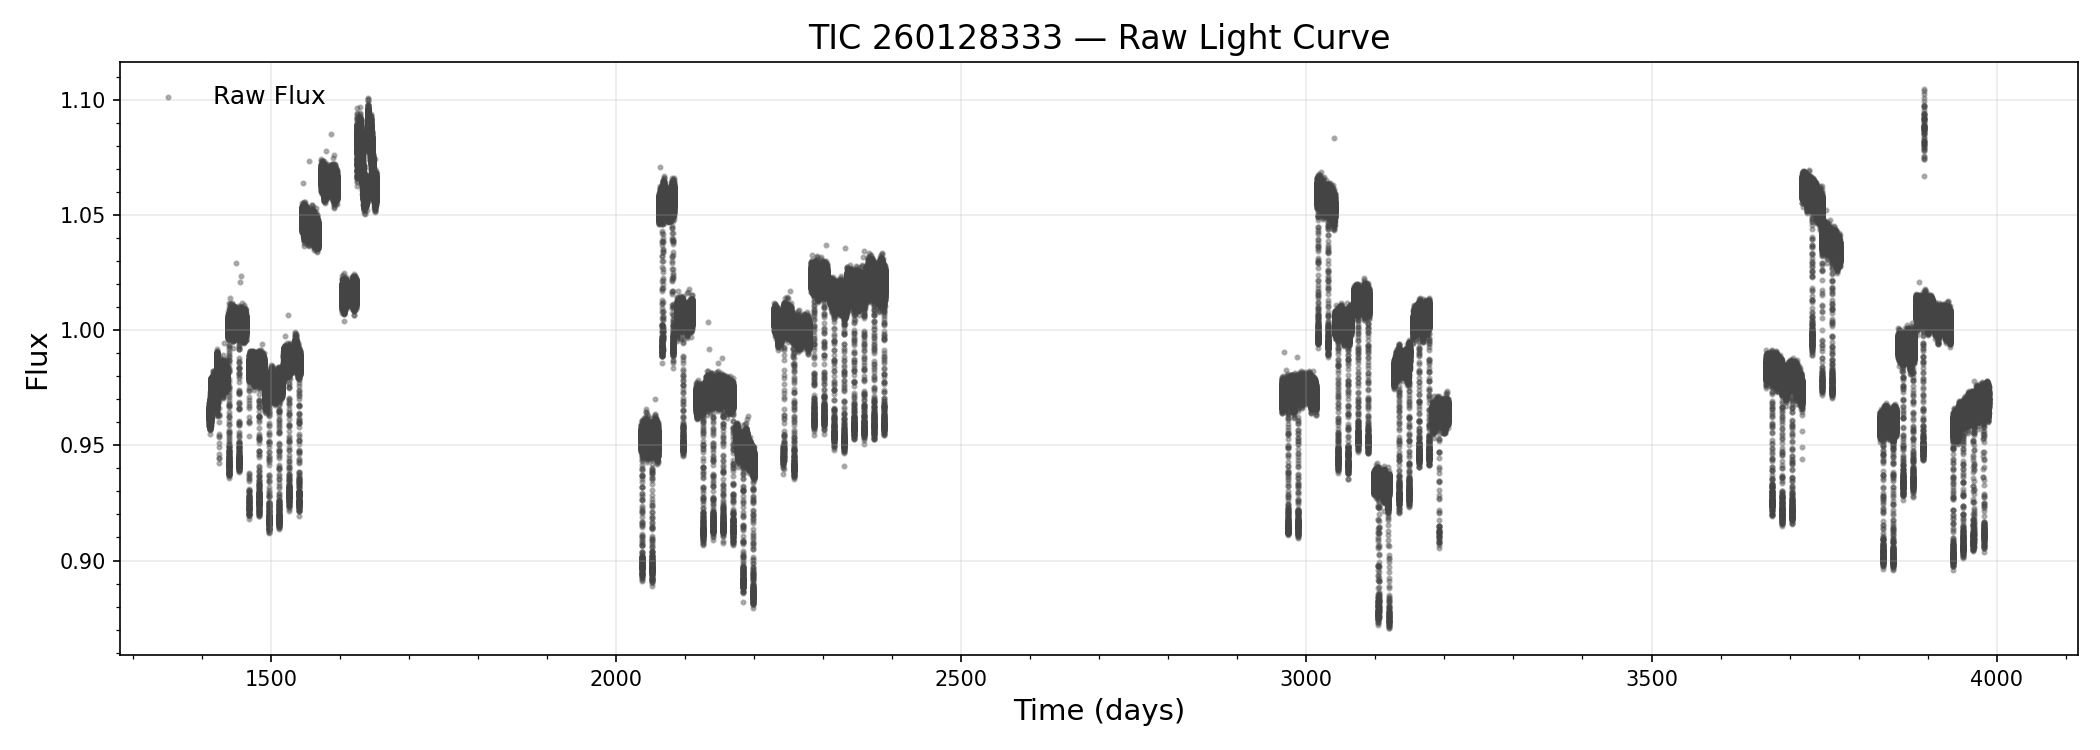


Displaying key diagnostic plots (in order):

Showing: Primary_Eclipse_Fit_260128333.png


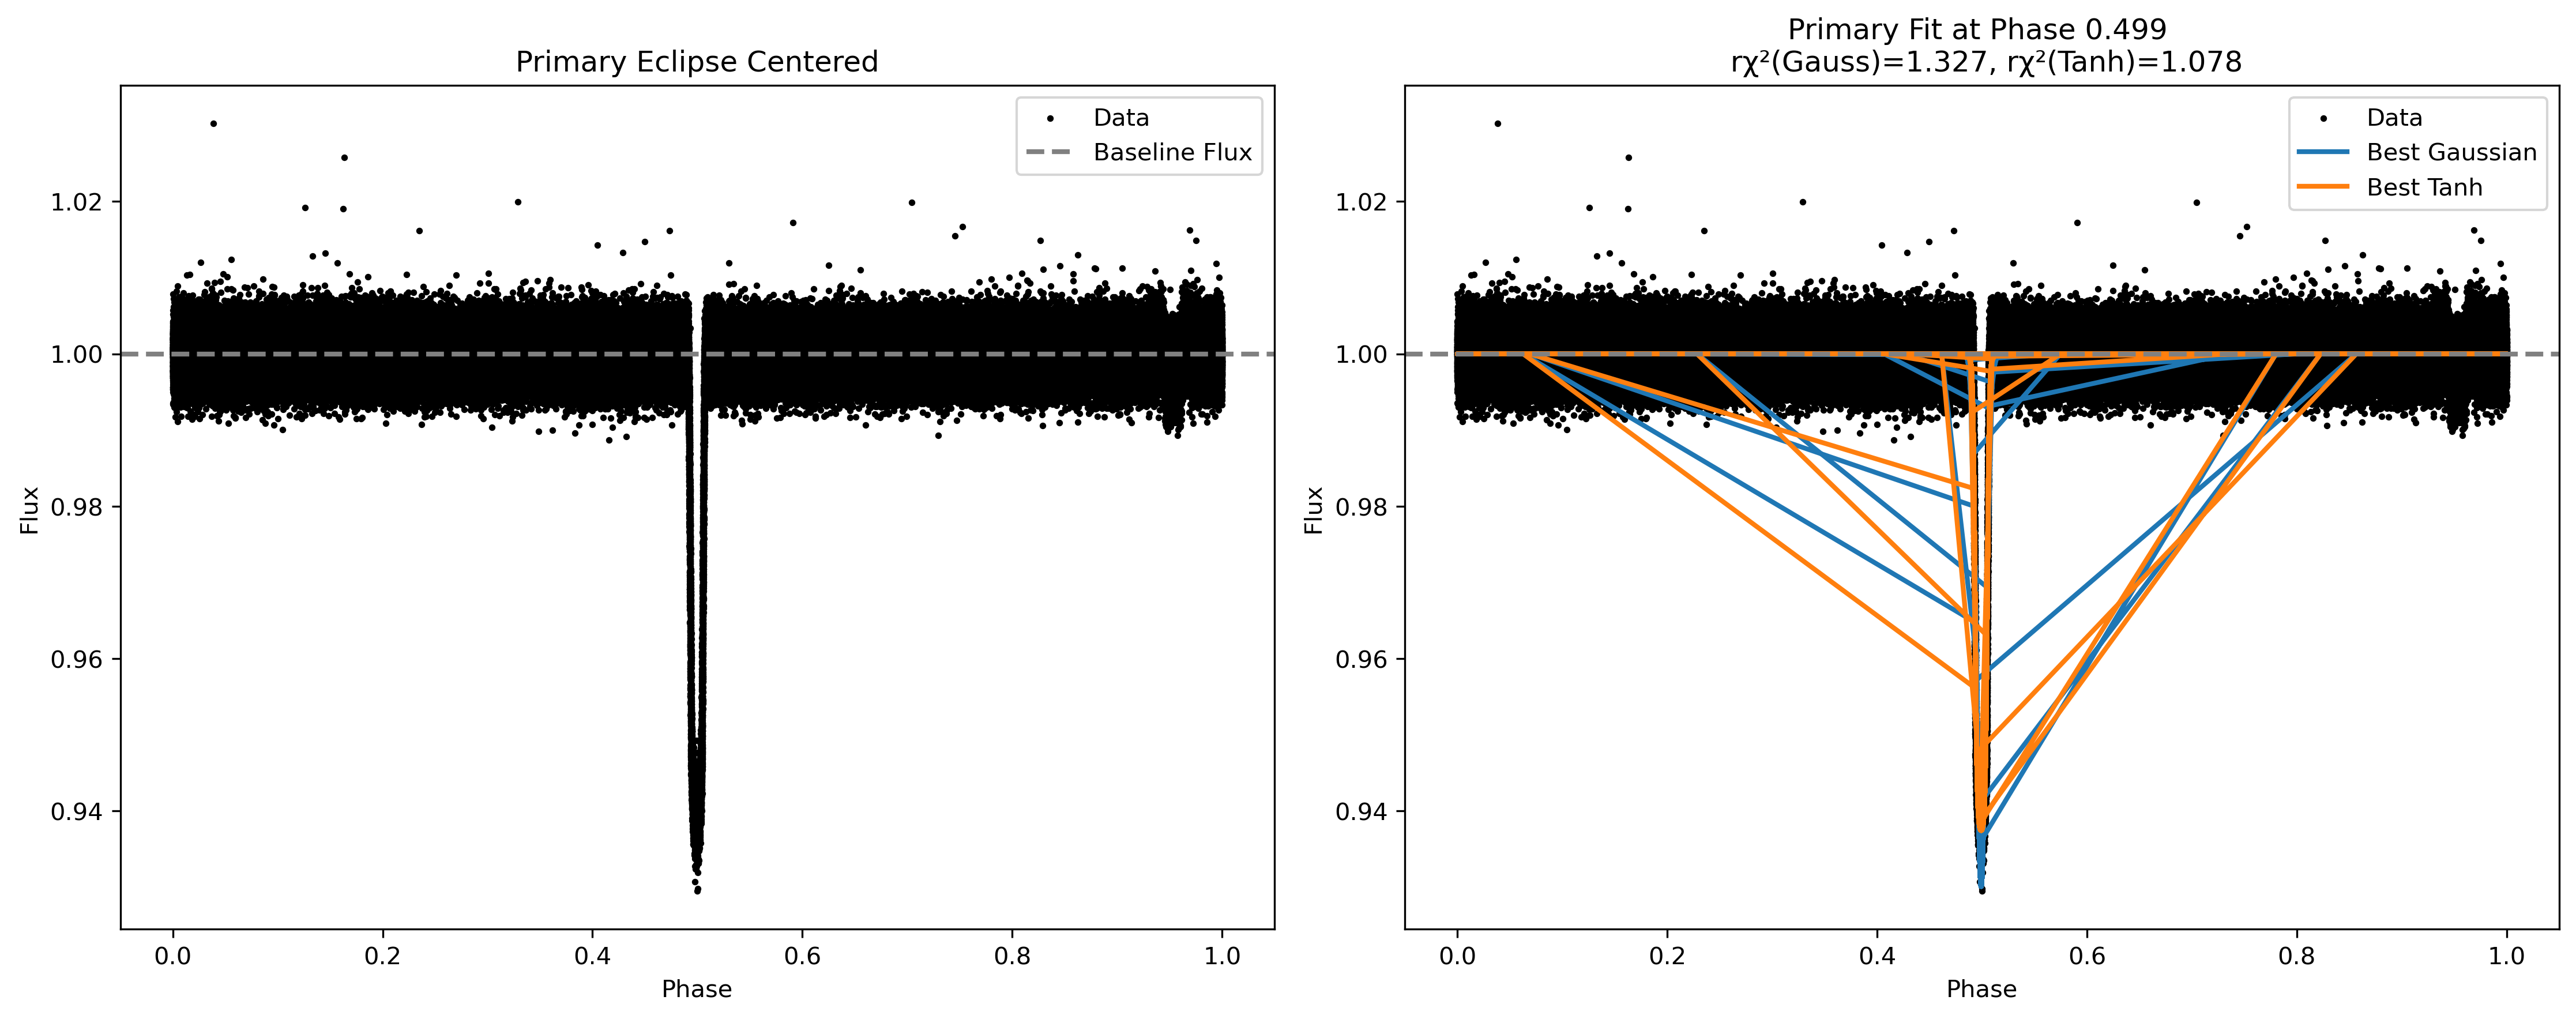

Showing: Secondary_Eclipse_Candidate_260128333.png


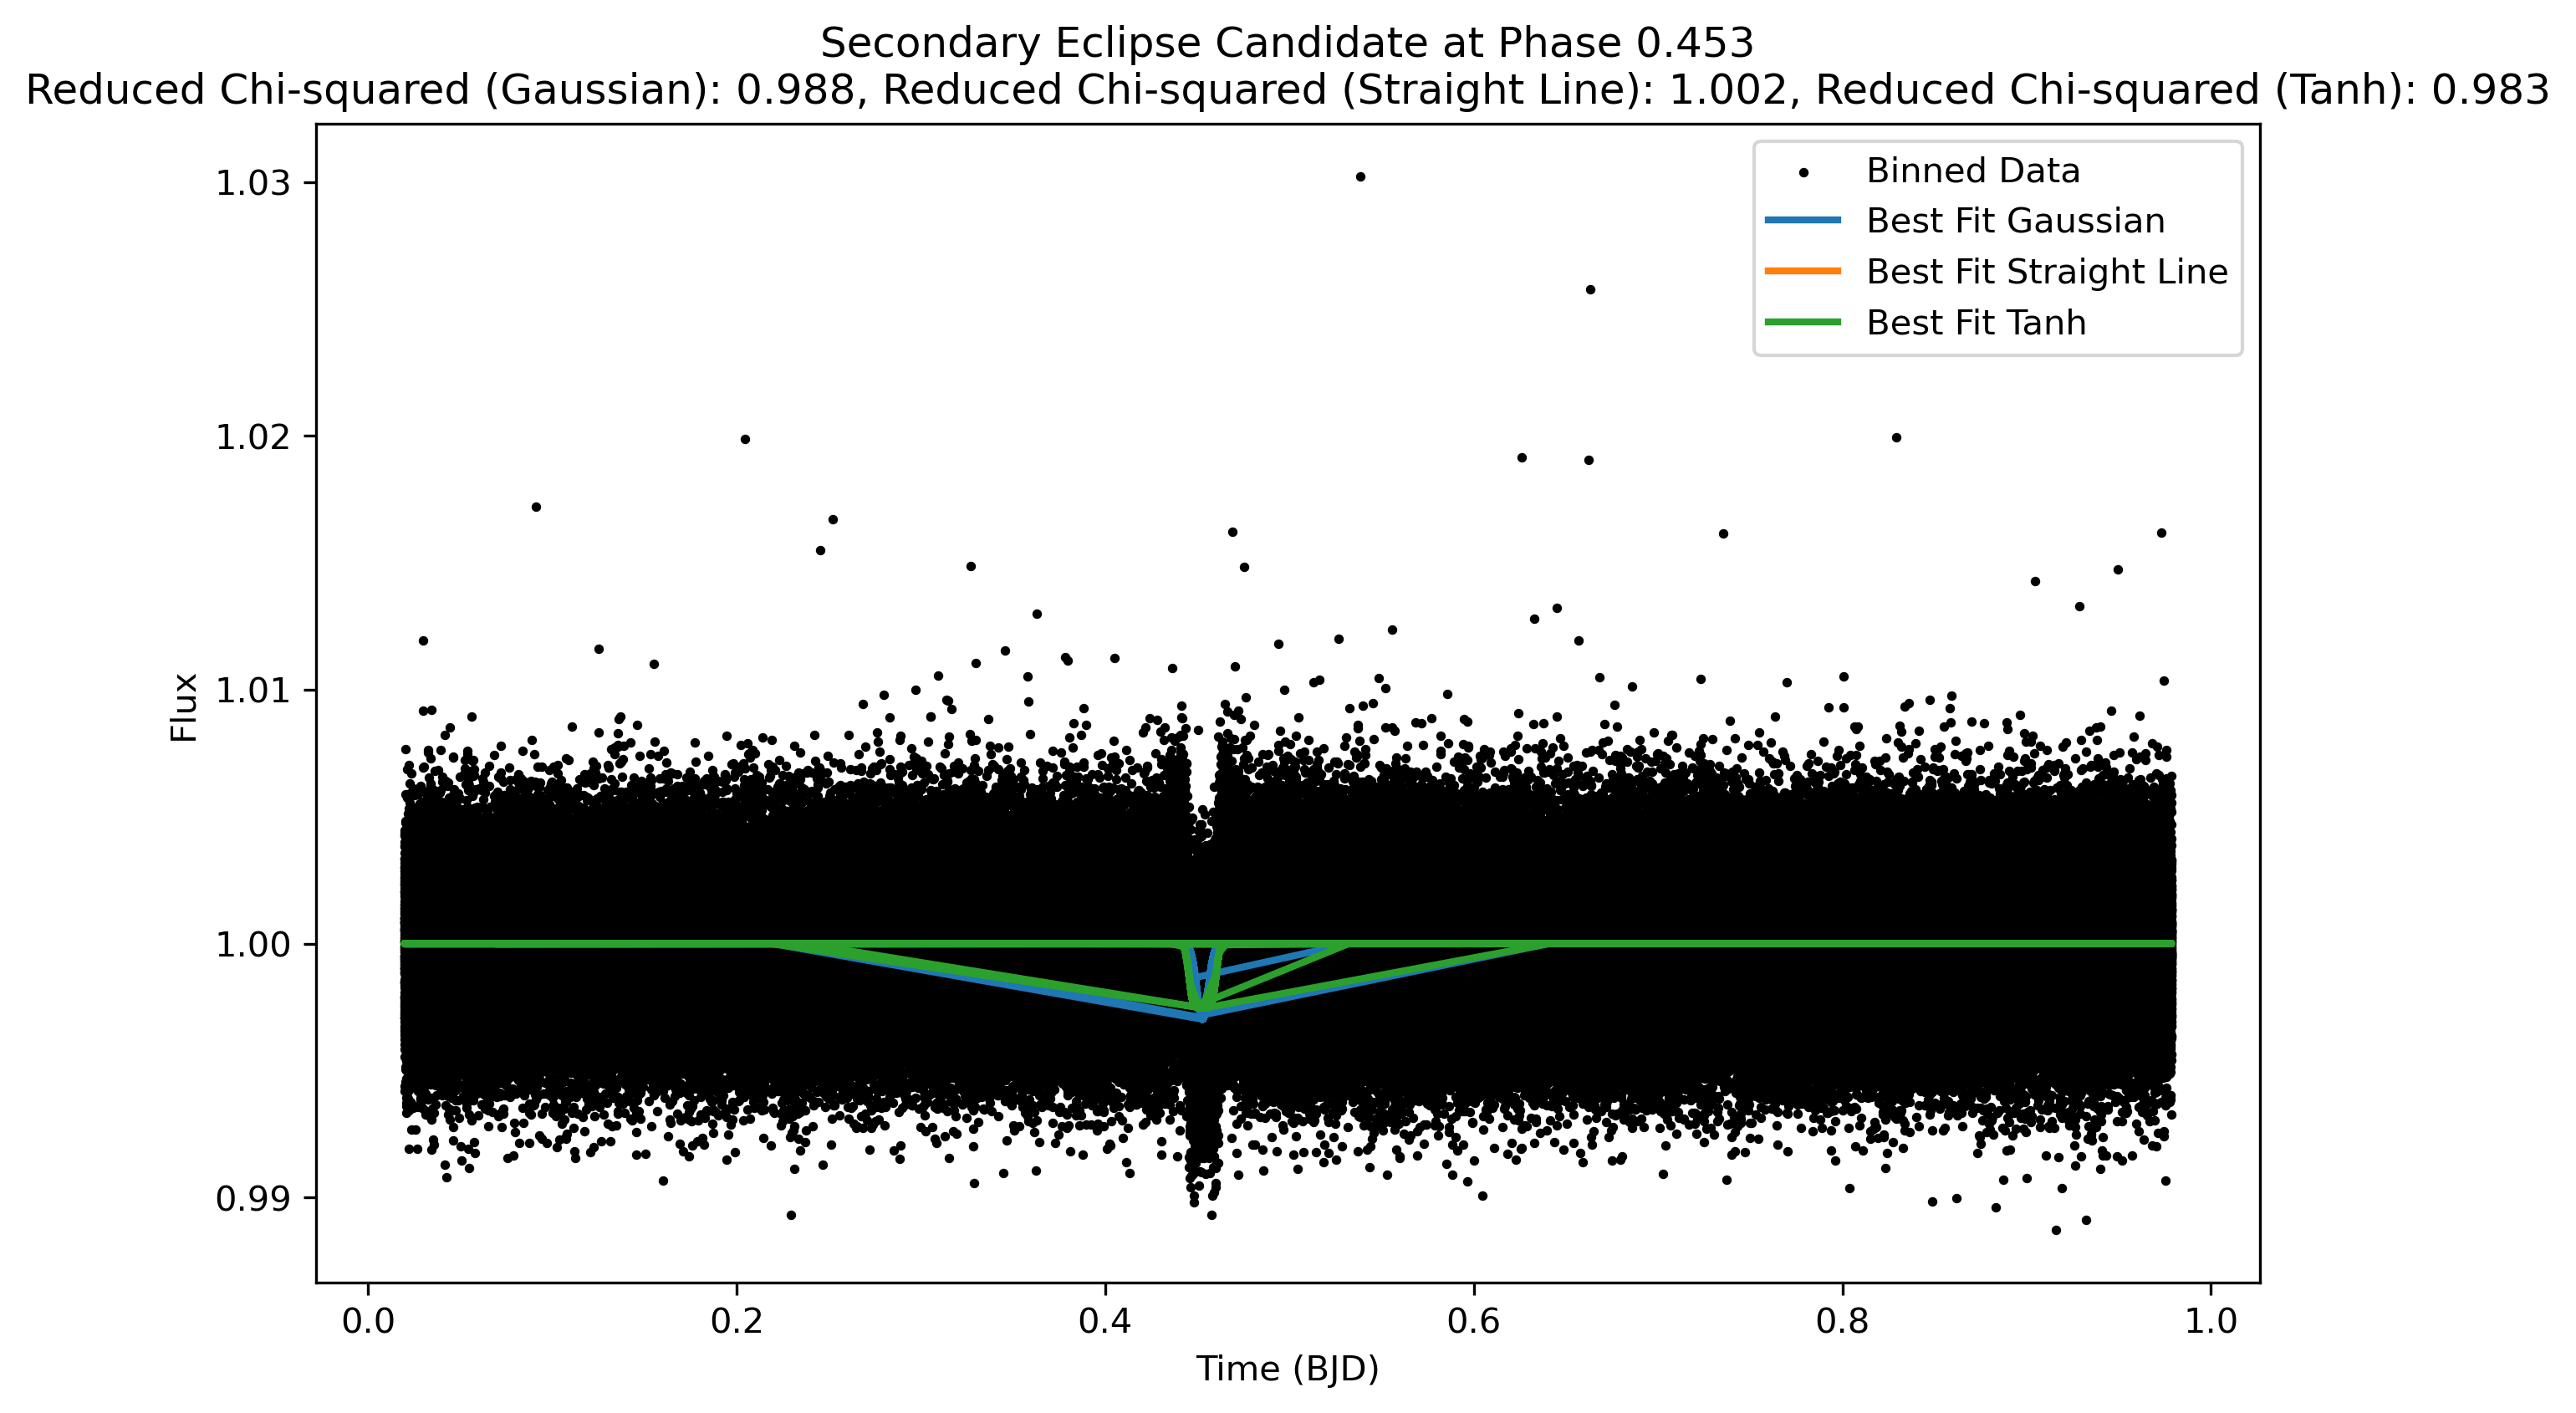

Showing: TIC_260128333_phase_folded_original_data.png


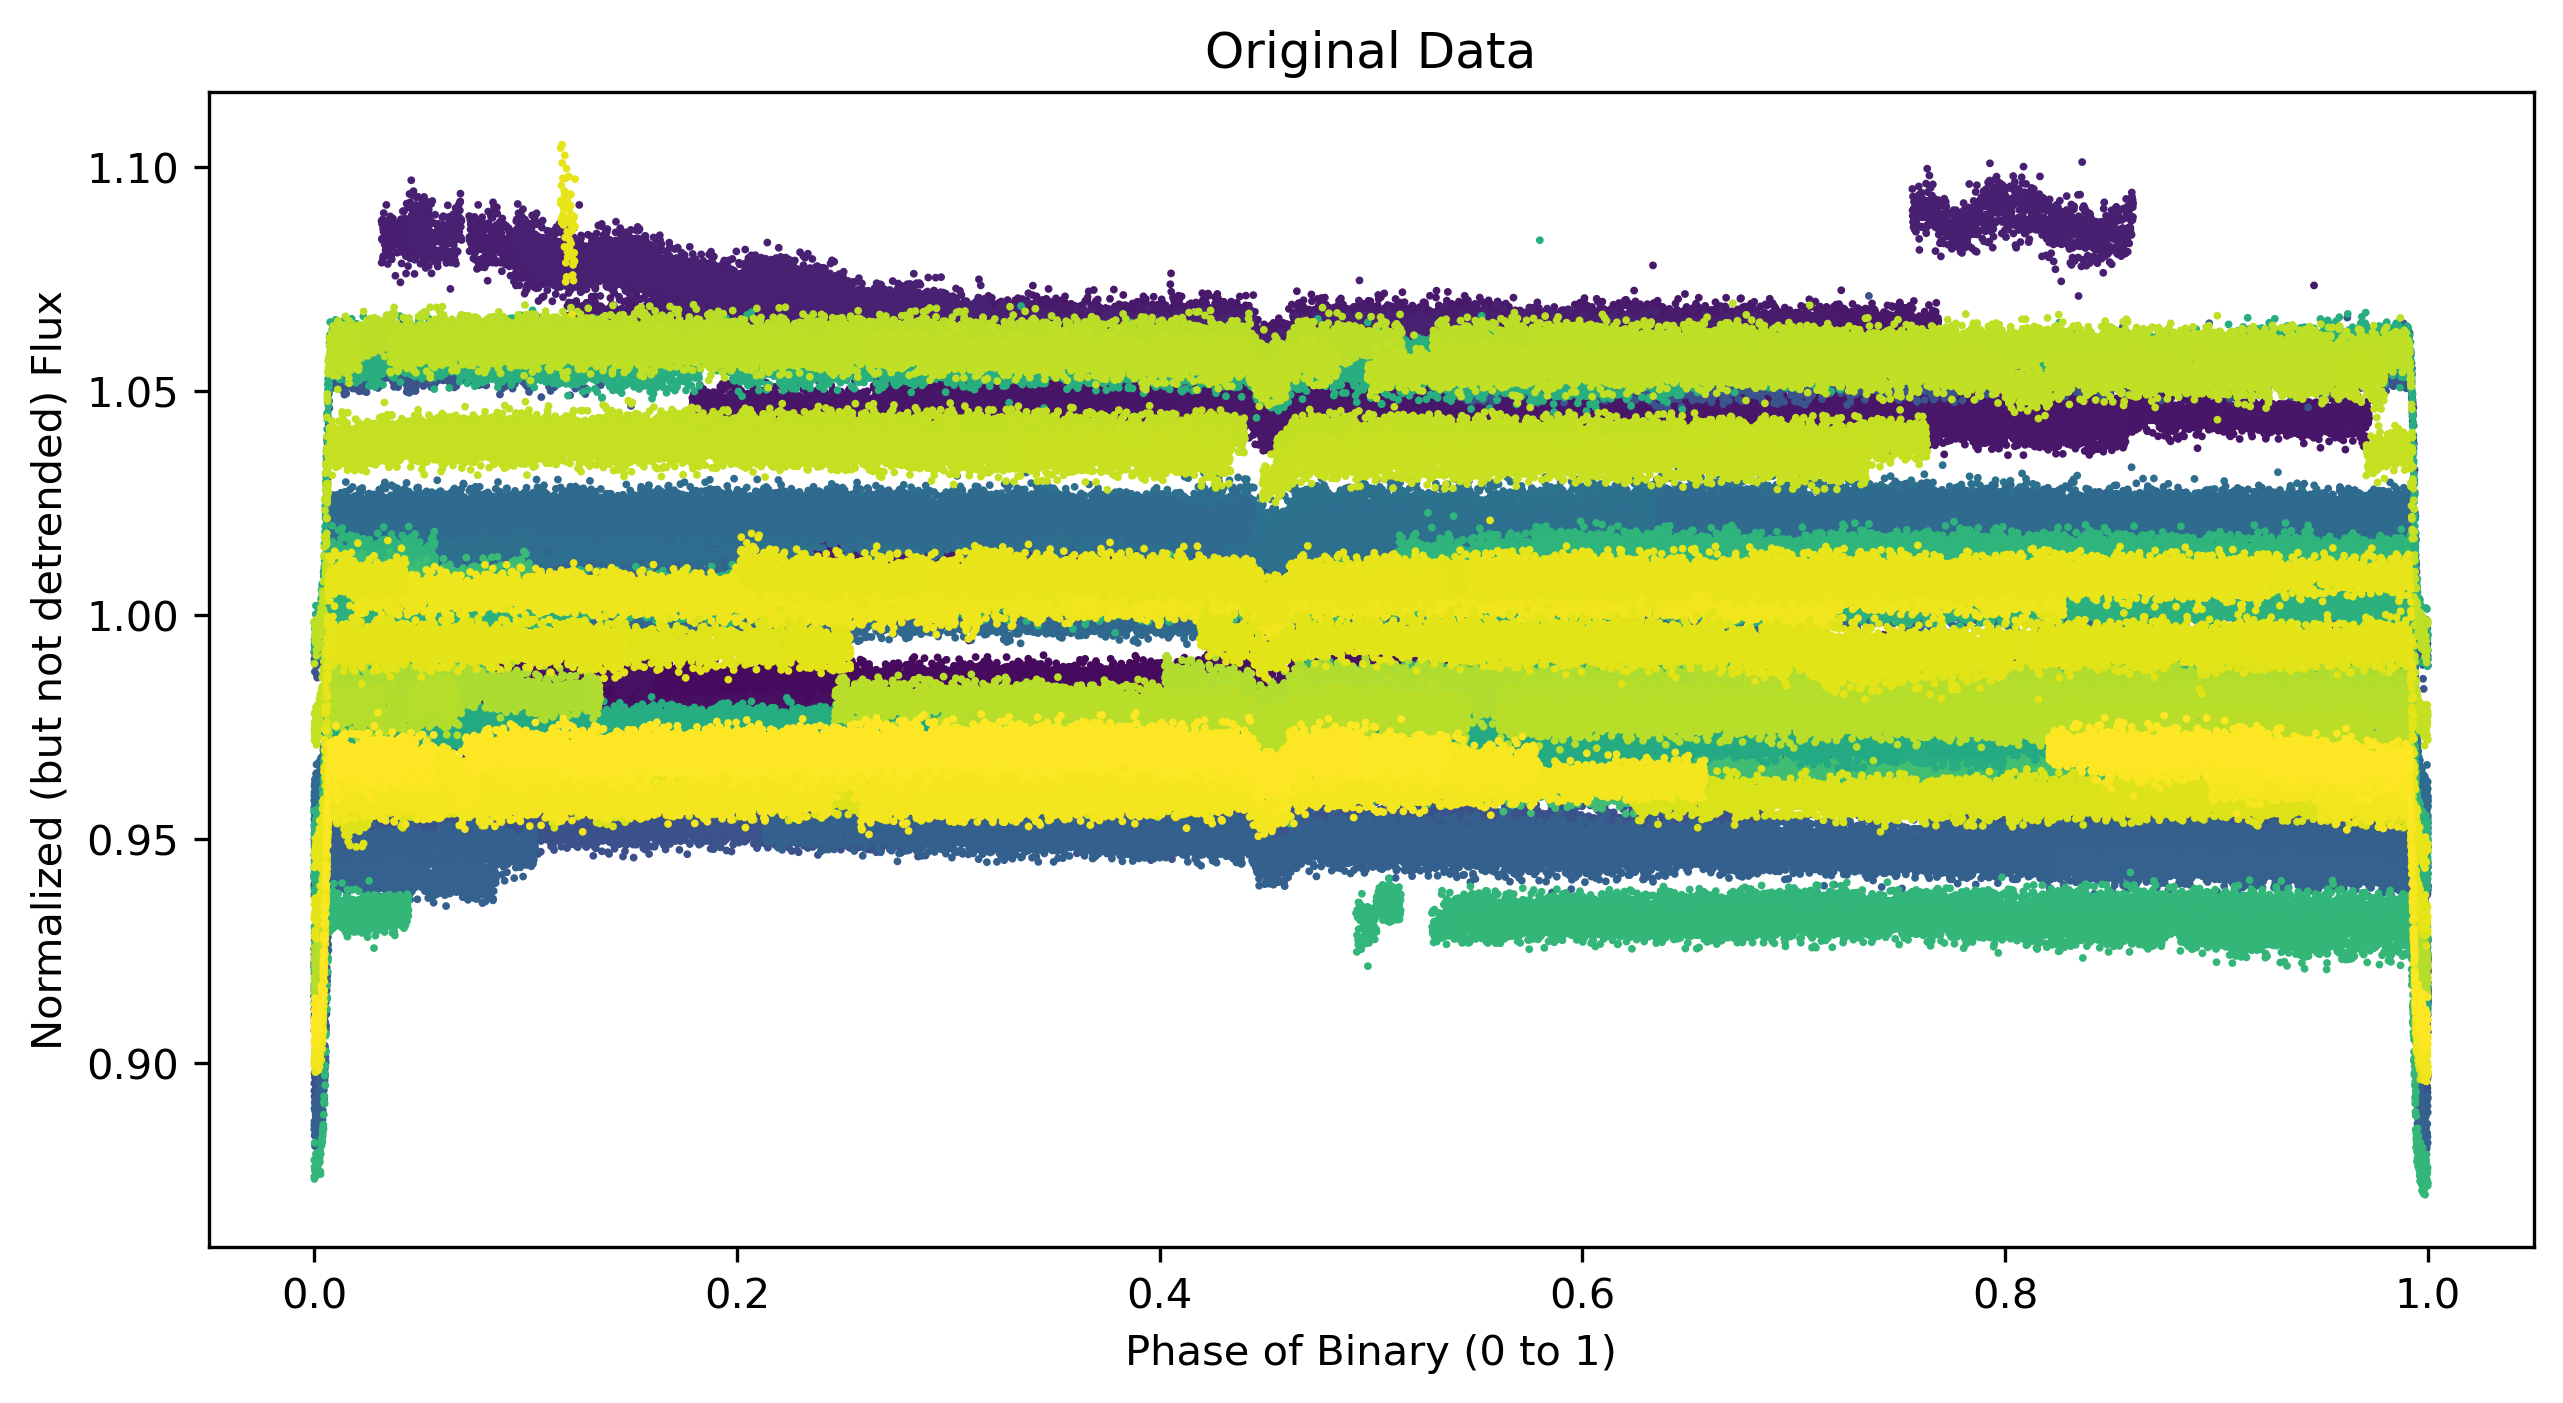

Showing: TIC_260128333_phase_folded_eclipses_removed.png


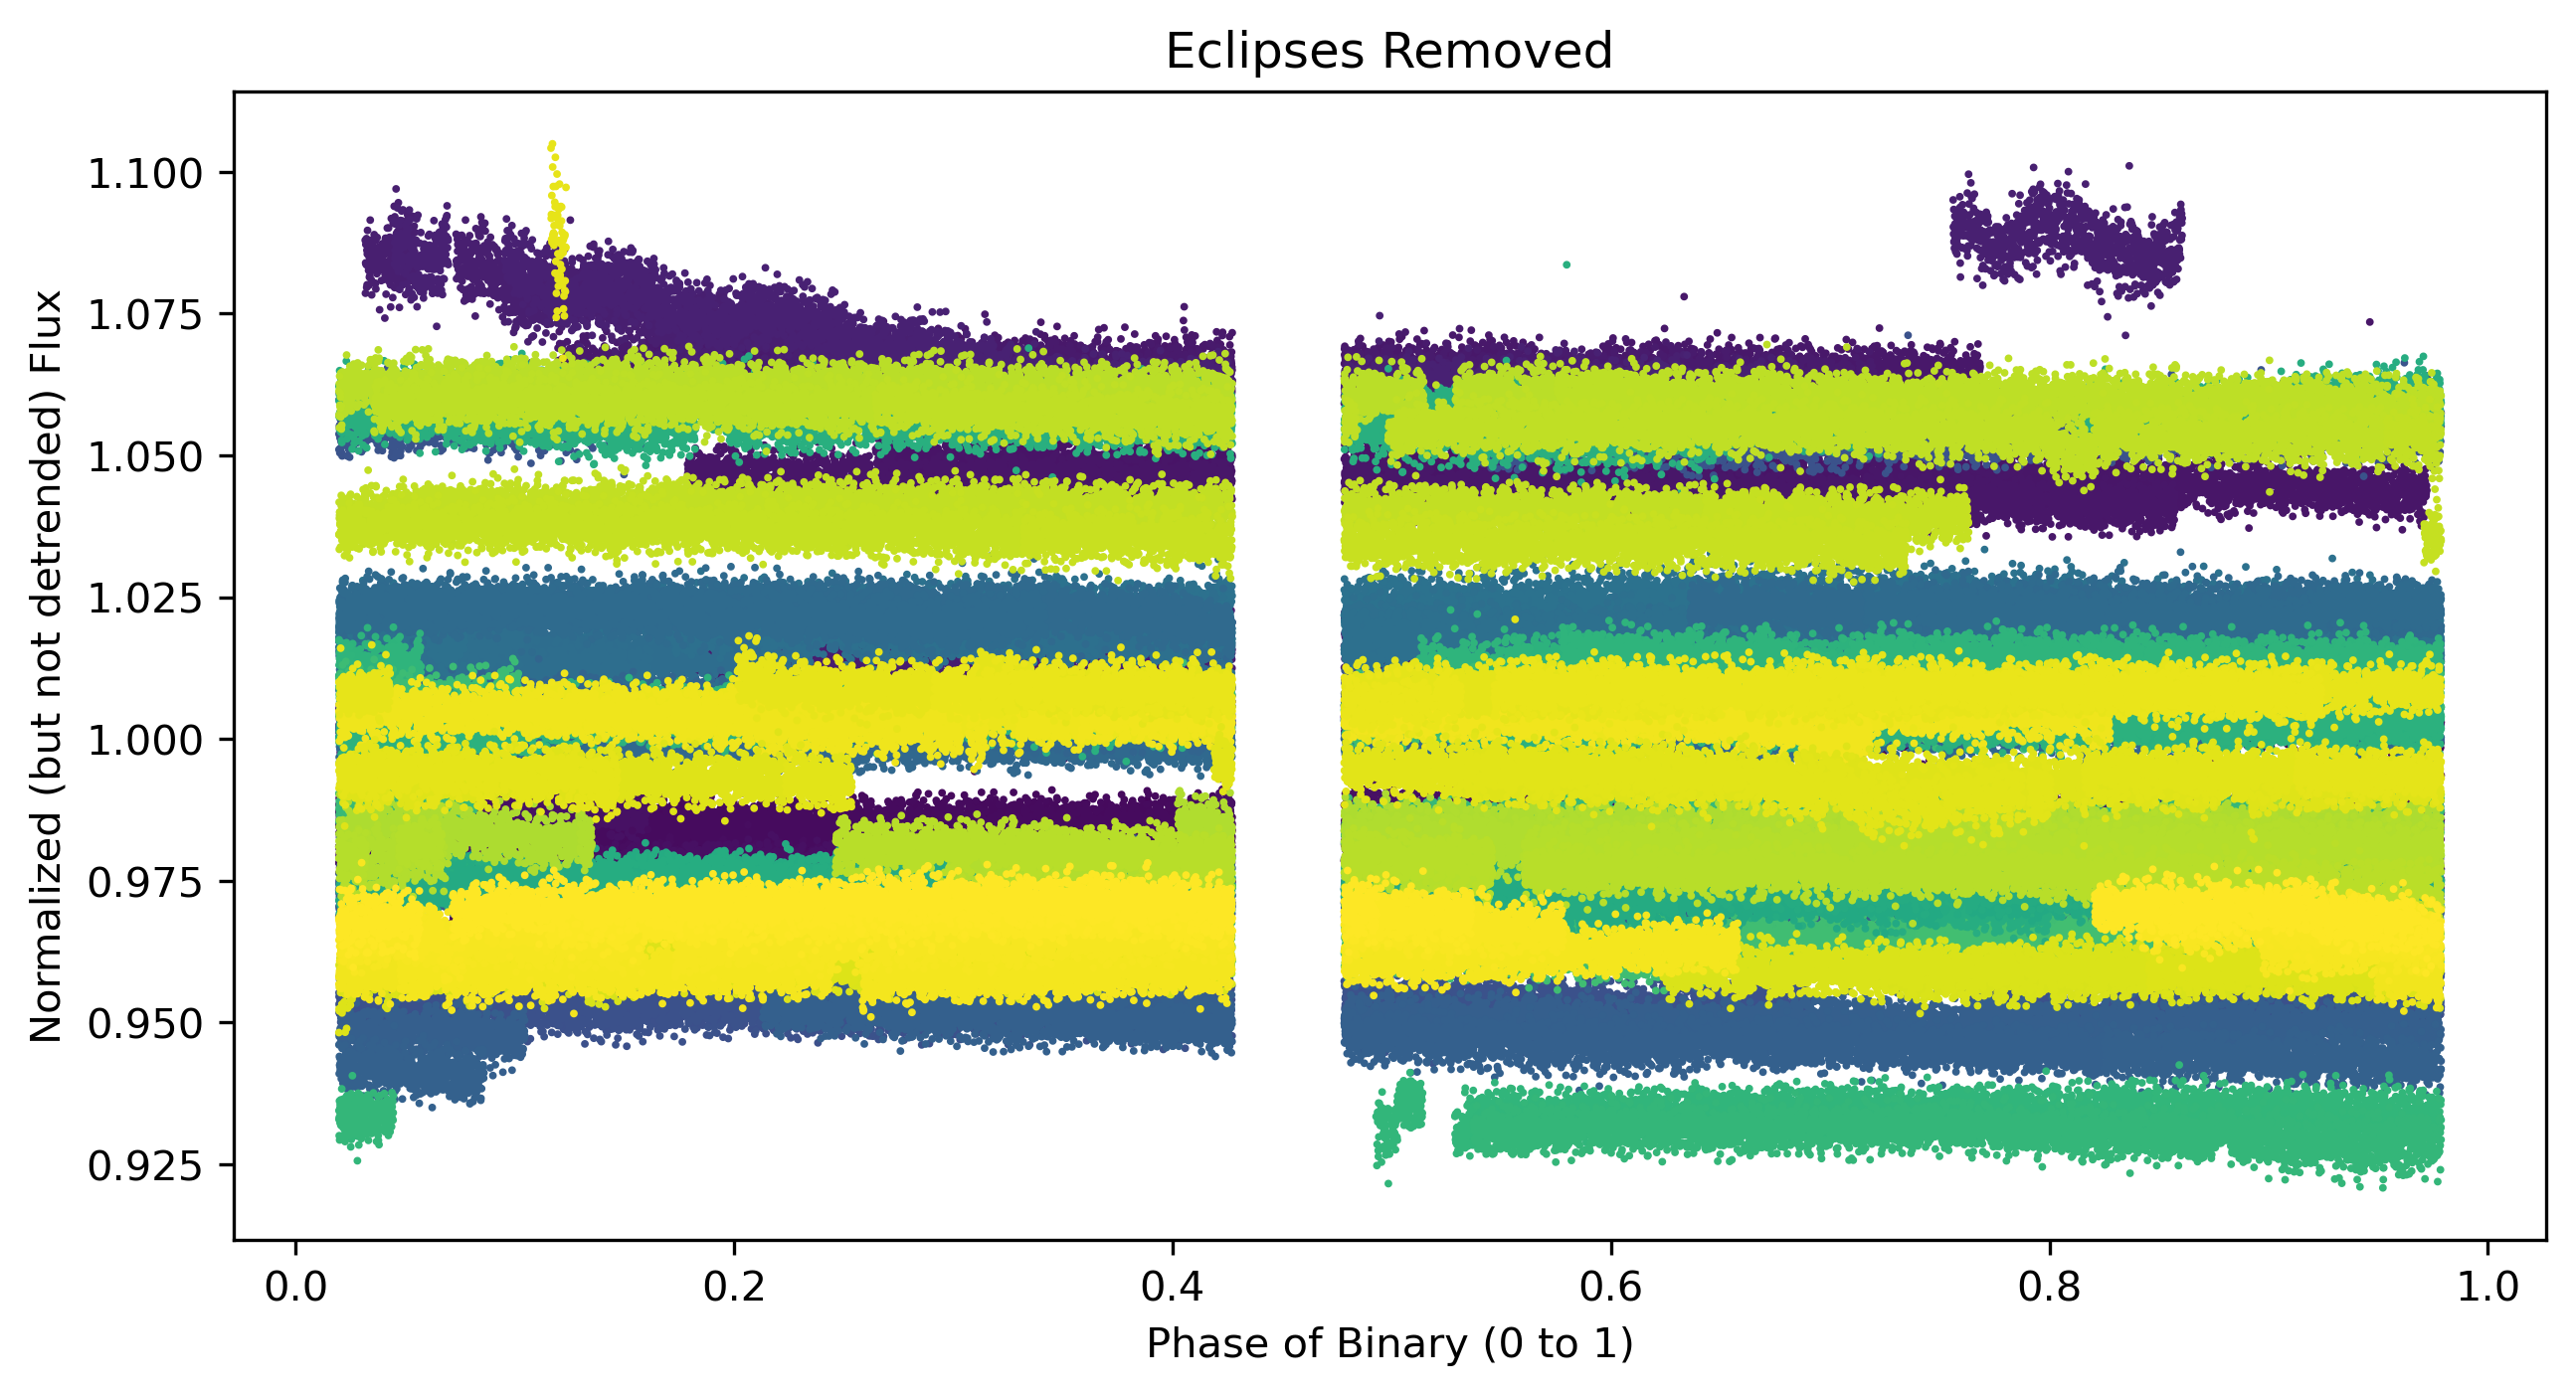

Showing: TIC_260128333_TutorialTOI1338_periodograms.png


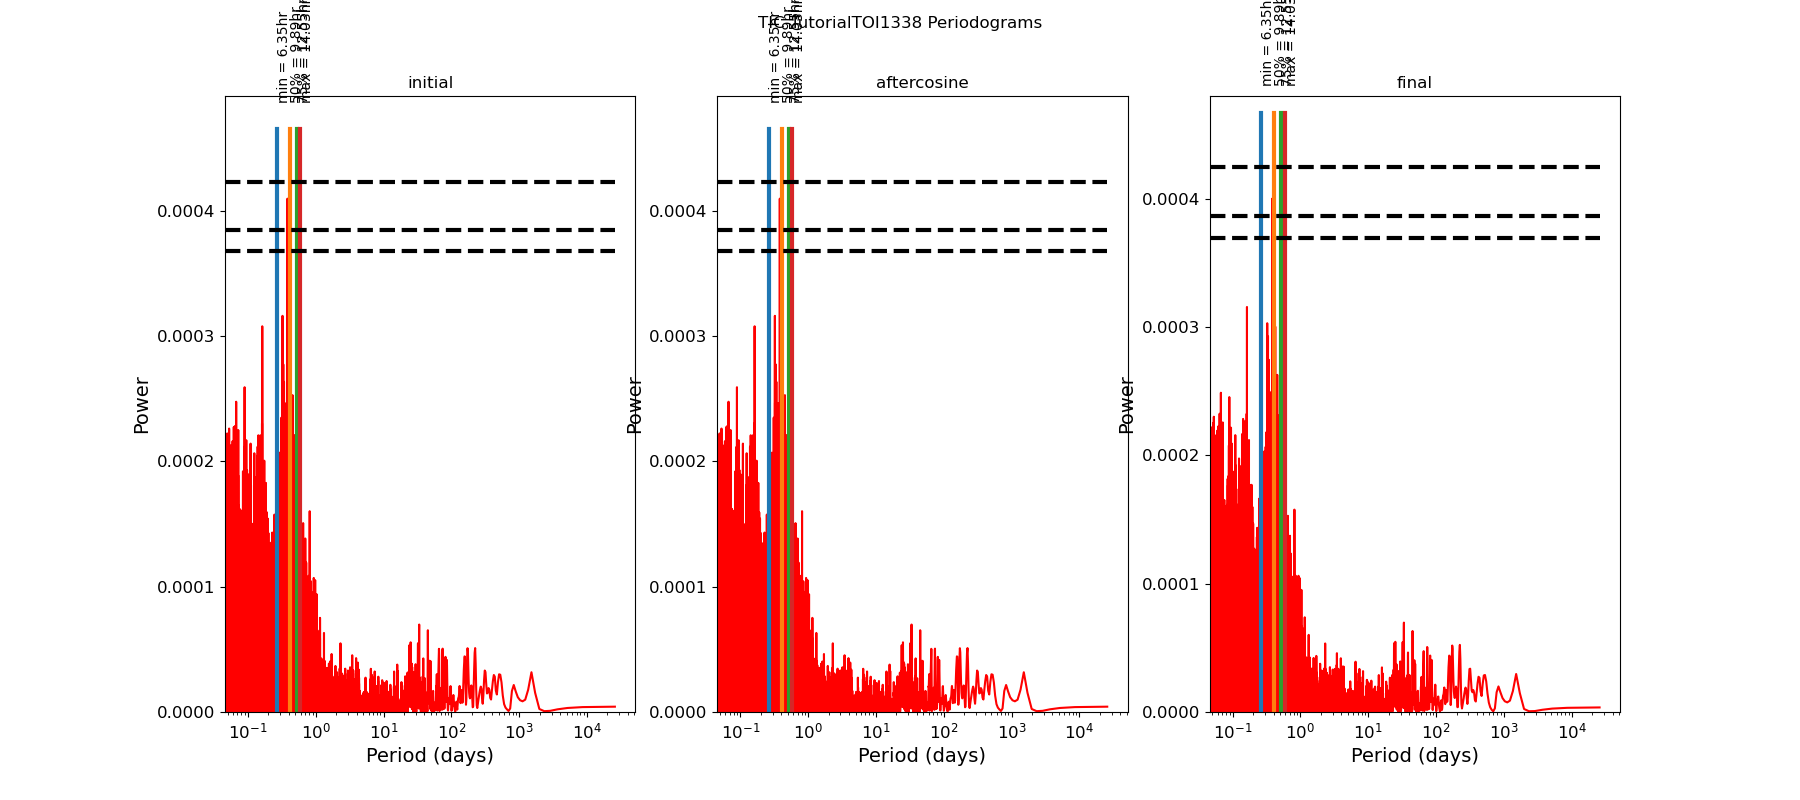

Showing: detrended light curve (fed into search)


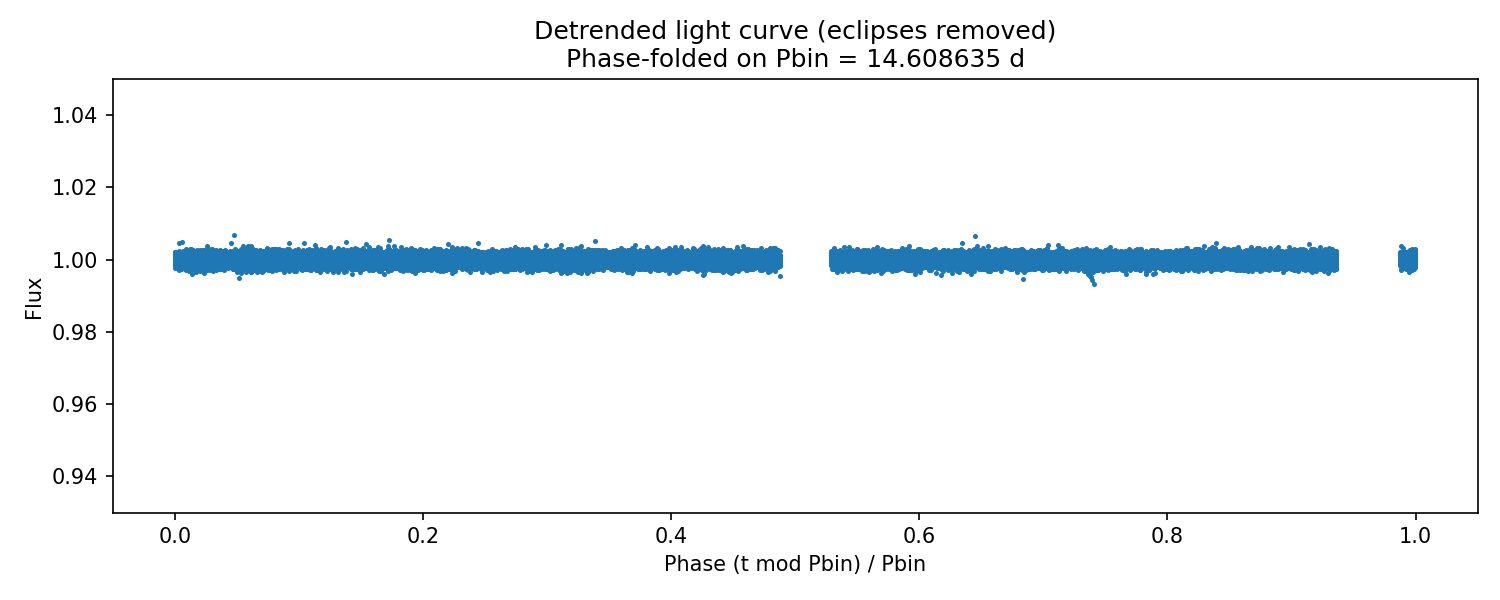

In [4]:
# Paths
fig_dir   = os.path.join("LightCurves", "Figures", DetrendingName)
data_prep = os.path.join("LightCurves", "Data_Preparation", DetrendingName)
raw_dir   = os.path.join("LightCurves", "Raw")
raw_file  = os.path.join(raw_dir, f"{ID}_raw.csv")

print("\nPlotting raw light curve:\n")

if os.path.exists(raw_file):

    # Load whitespace-delimited: [time_sec, flux, flux_err]
    raw = np.genfromtxt(raw_file)
    if raw.ndim == 1:
        raw = raw.reshape(1, -1)

    time_sec  = raw[:, 0]
    flux_raw  = raw[:, 1]
    time_days = time_sec / 86400.0

    # Make sure folder exists for the temp file
    os.makedirs(data_prep, exist_ok=True)
    tmp_png = os.path.join(
        data_prep,
        f"{mission}_{ID}_raw_lightcurve_tmp_{uuid.uuid4().hex}.png"
    )

    # Plot layout
    plt.figure(figsize=(14, 5))

    plt.scatter(
        time_days, flux_raw,
        s=4, color="#444444", alpha=0.35,
        label="Raw Flux"
    )

    plt.xlabel("Time (days)", fontsize=14)
    plt.ylabel("Flux", fontsize=14)
    plt.title(f"{mission} {ID} — Raw Light Curve", fontsize=16)

    plt.grid(True, alpha=0.25)
    plt.minorticks_on()
    plt.legend(frameon=False, fontsize=12)

    plt.tight_layout()
    plt.savefig(tmp_png, dpi=150)
    plt.close()

    print("Showing: raw light curve")
    display(Image(filename=tmp_png, width=950))

    # Remove temp file so it doesn't persist on disk, we only plot the raw light curve for purposes of this tutorial
    try:
        os.remove(tmp_png)
    except OSError:
        pass

else:
    print(f"Missing raw file: {raw_file}")

important_figs = [
    f"Primary_Eclipse_Fit_{ID}.png",
    f"Secondary_Eclipse_Candidate_{ID}.png",
    f"{mission}_{ID}_phase_folded_original_data.png",
    f"{mission}_{ID}_phase_folded_eclipses_removed.png",
    f"{mission}_{ID}_{DetrendingName}_periodograms.png",
]

print("\nDisplaying key diagnostic plots (in order):\n")

for fname in important_figs:
    # Look in Figures first, then Data_Preparation
    possible_paths = [
        os.path.join(fig_dir, fname),
        os.path.join(data_prep, fname),
    ]
    
    displayed = False
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Showing: {fname}")
            display(Image(filename=path, width=950))
            displayed = True
            break
    
    if not displayed:
        print(f"Missing: {fname}")

# Now, let's take a look at the detrended light curve with the eclipses removed
# This is what gets read into the search
detrended_dir = os.path.join("LightCurves", "Processed", DetrendingName)
detrended_path = os.path.join(detrended_dir, f"{mission}_{ID}_{DetrendingName}_detrended.csv")
detrended_lc = pd.read_csv(detrended_path, delim_whitespace=True)

# Load binary starting params (key,value CSV)
binaryParams_path = os.path.join(detrended_dir, f"{mission}_{ID}_{DetrendingName}_binaryStartingParams.csv")
binaryParams = pd.read_csv(binaryParams_path, header=None, names=["param", "value"])

# Extract period
period = binaryParams.loc[binaryParams["param"] == "Pbin (days)", "value"].iloc[0]
period = float(period) # make sure it's numeric

# Load in our detrended light curve time and flux
t = detrended_lc.iloc[:, 0].to_numpy()
f = detrended_lc.iloc[:, 1].to_numpy()

# Phase fold 
phase = (t % period) / period
# Sort by phase
order = np.argsort(phase)

# --- Plot detrended LC fed into the search ---
tmp_png = os.path.join(
    data_prep,
    f"{mission}_{ID}_{DetrendingName}_detrended_phasefolded_tmp_{uuid.uuid4().hex}.png"
)

plt.figure(figsize=(10, 4))
plt.scatter(phase[order], f[order], s=2)
plt.xlabel("Phase (t mod Pbin) / Pbin")
plt.ylabel("Flux")
plt.ylim(0.93, 1.05)
plt.title(
    f"Detrended light curve (eclipses removed)\n"
    f"Phase-folded on Pbin = {period:.6f} d"
)
plt.tight_layout()
plt.savefig(tmp_png, dpi=150)
plt.close()

print("Showing: detrended light curve (fed into search)")
display(Image(filename=tmp_png, width=950))

# Clean up temp file
try:
    os.remove(tmp_png)
except OSError:
    pass



---
## **Search**

`Stanley_FindPlanets()` performs the circumbinary planet search by forward modeling an N body grid of planetary orbits and comparing the resulting transit masks to the detrended light curve. For this TOI 1338 tutorial, the search is run in parallel across four sectors, using a period range tailored to the known orbital period of TOI 1338b.

The search proceeds as follows:

- It constructs a grid of **planetary orbital parameters**, including the orbital period *Pp*, eccentricity *ep*, argument of periastron *omegap*, and true anomaly *thetap*. The binary parameters were established during the detrending stage and remain fixed in this example.

- For each grid point, an **N body–based transit mask** is generated that predicts where transits should occur.

- Each mask is compared to the detrended light curve and assigned a **significance value σ**, indicating how well that planetary configuration explains the data. Interpolation between true anomaly samples is used when `N_interp > 1`.

- All σ grids and intermediate results are written to `PlanetSearchOutput/<SearchName>/` for later inspection and visualization.

In this TOI 1338 notebook, `Stanley_FindPlanets` is configured to balance speed and completeness, making it suitable for real time demonstration while still capturing the full circumbinary search behavior.

### Notebook Search Configuration

### **Notebook Search Configuration**

- `totalSectors = 4`  
  The data are split into four sectors (quarters), each searched separately.

- `currentSector = 1`  
  The parallel launch executes the search across all four sectors. These sectors are internal analysis chunks used by the search code and are not equivalent to TESS observing sectors.

- `OnCluster = 0`  
  Enables local progress bar output.

- `parallel = 1`
Turns on parallel execution so multiple sectors (and/or trial periods, depending on how your wrapper is written) can be processed concurrently. If `parallel = 0`, the code runs in a single process. 

- `cpuCount = N`
Sets the number of CPU workers to use when `parallel = 1`. A good default is the number of physical cores you want to dedicate (e.g., `cpuCount = 4` on a laptop; larger on a node). If cpuCount is larger than what your machine/node actually allocates, you won’t get a speedup and may slow down due to overhead. If `cpuCount = 0` the code automatically uses all available CPU cores on the current machine or allocated node.

- `interpolationValue = 2`  
  Enables light interpolation in true anomaly.

- `boundsType = "days to days"`  
  The period grid is specified directly in days.

- `minValue = 85`, `maxValue = 105`  
  A **prior informed window** centered on the expected period of Kepler 47b. This significantly reduces runtime while retaining sensitivity to the planet.

- `e_max_planet = 0.0`  
  Planet eccentricity is fixed to zero for this demonstration.

This call does not itself produce many human-readable plots; instead, it generates the
high-dimensional search results that will be summarized and visualized in the **analysis**
step.

### **Tutorial Goals**

1. Verify that the TOI 1338 circumbinary search runs successfully in parallel across multiple sectors.  
2. Understand where outputs are stored and how they are used by the analysis stage.  
3. Use the resulting σ grids to examine the detectability of TOI 1338b within the constrained search window.

In [ ]:
TotalSectors = 4
OnCluster = 0
SearchName = 'TutorialSearch_TOI1338'
SystemName = SystemName
DetrendingName = DetrendingName
N_interp = 2
BoundsType = 'days to days'
MinValue = 85
MaxValue = 105
# Note that we collapse the eccentricity grid down for the sake of runtime 
e_max_planet = 0.0

args = Namespace(
    searchName=SearchName,
    systemName=SystemName,
    detrendingName=DetrendingName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
    parallel=1,
    cpuCount=0, # use all cpus available
    interpolationValue=N_interp,
    boundsType=BoundsType,
    minValue=MinValue,
    maxValue=MaxValue,
    e_max_planet=e_max_planet,
)

SFP.parallel(args)
print("Search finished for all sectors (parallel).")

[2025-12-17 17:58:12.071488] Entering parallel(args)
[2025-12-17 17:58:12.173594] Launching pool.map over sectors 1..4


---
## **Analysis**

After the search has completed, we call `runAnalysisModule` to turn the high-dimensional
search outputs into a small set of **human-interpretable diagnostics**.

Conceptually, `runAnalysisModule`:

- **Loads the search context and detrended light curve**  
  using the `simInfo` file, the saved detrended CSV associated with the same `DetrendingName`,
  and the binary starting parameters.

- **Reads and aggregates the search grids**  
  by loading the `searchParameters_array` and concatenating the
  `searchResults_array_*` files in `PlanetSearchOutput/<SearchName>/`
  across all θₚ sectors.

- **Builds a 1D detection statistic as a function of planet period**  
  by combining the multi-dimensional significance grid over the remaining
  parameters (masses, binary elements, eccentricity *eₚ*, argument of periastron *ωₚ*,
  and true anomaly *θₚ*), and then computing an SDE curve vs. period.

- **Selects the best-fit model at the SDE peak**  
  and extracts the corresponding `(Pₚ, eₚ, ωₚ, θₚ)` combination, along with the
  associated binary parameters.

- **Reconstructs transit times and durations** for the best-fit configuration  
  and generates:
  - A **TTV (Transit Timing Variations)** plot  
  - A **TDV (Transit Duration Variations)** plot  
  - A concise, human-readable summary text file  
  - Helper files with transit windows and discovered transit lists for downstream vetting.

In this tutorial, we only have **one sector**, but we still use `runAnalysisModule` so that
the workflow matches the full multi-sector/cluster use case:

- The same analysis call will work if `totalSectors > 1`.  
- The module automatically discovers and loads all sector outputs associated with
  `searchName` and `systemName`.  
- The returned `result` dictionary provides a compact summary (e.g. peak SDE value
  and best-fit period) that we can inspect directly in the notebook.


In [ ]:
# Run analysis module to collate results from all sectors
result = stanley_analysis.runAnalysisModule(
    searchName=SearchName,
    systemName=SystemName,
    totalSectors=TotalSectors,
    currentSector=currentSector,
    onCluster=OnCluster,
)

print("Analysis finished.")
print("Summary:")
for k, v in result.items():
    print(f"  {k}: {v}")


[2025-12-16 19:34:55.988395] Analysis expecting simInfo at: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\PlanetSearchOutput\TutorialSearch_TOI1338\TIC_260128333_simInfo.npy
Loading results for searchName = TutorialSearch_TOI1338, systemName = TIC260128333, detrendingName = TutorialTOI1338
4 sector(s) loaded
Create 1D SDE
[SDE diag] N=339 kept=328 (96.76%) initialSTD=1.03283 clipSTD=0.631634 denom=clipSTD max=14.245
[SDE] Max=14.245 at 96.10668 d
1D SDE created
Getting best fitting transit times
meanPlanetTransitInterval (sec): 8133688.282574222
scaledWindowTime size: 309, totalWindowFlux size: 309
meanScaledFlux_time size: 14, meanScaledFlux size: 14
sigma_solutionOld = 16.30184849752937
meanFlux_solution = -0.0009061999260667698
Analysis finished.
Summary:
  status: ok
  mission: TIC
  ID: 260128333
  DetrendingName: TutorialTOI1338
  SDE_1d_max: 14.244568548354941
  period_sdeMax_days: 96.10667514777066
  TTV_png: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\Pla

---
## **Search & Analysis Diagnostics and Results**


Search and analysis diagnostic plots:

Showing: 260128333_TICSDEpaper.png


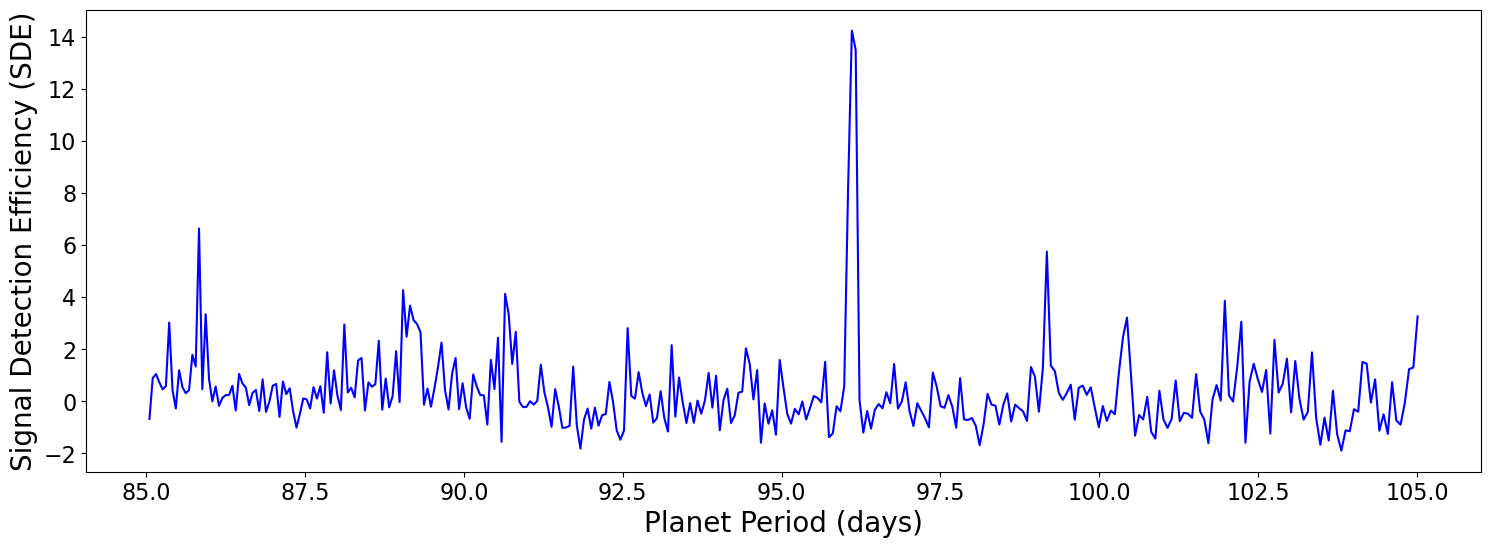

Showing: TIC_260128333_IndividualPlanetTransitsWiderWindow.png


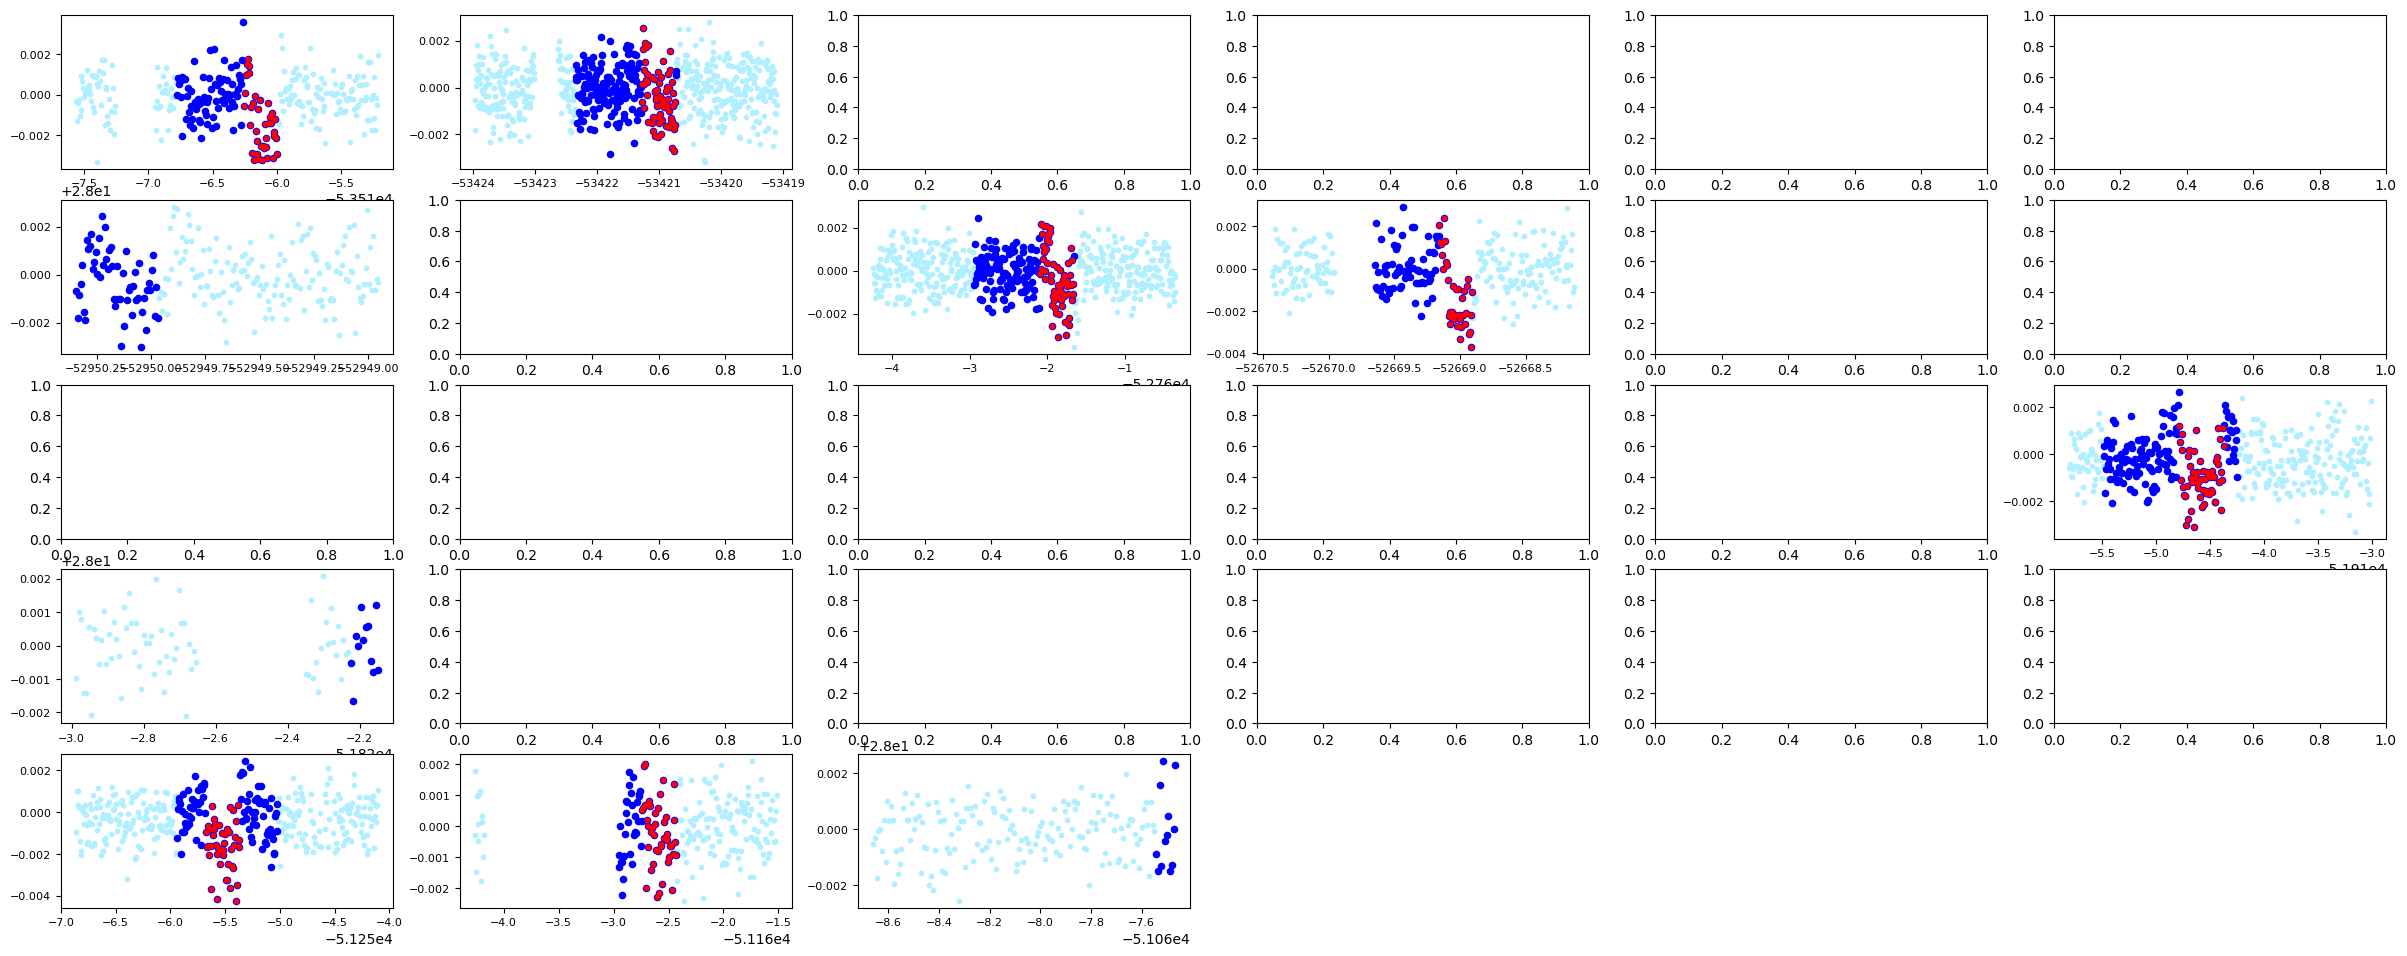

Showing: TIC_260128333_FoldedPlanetTransits.png


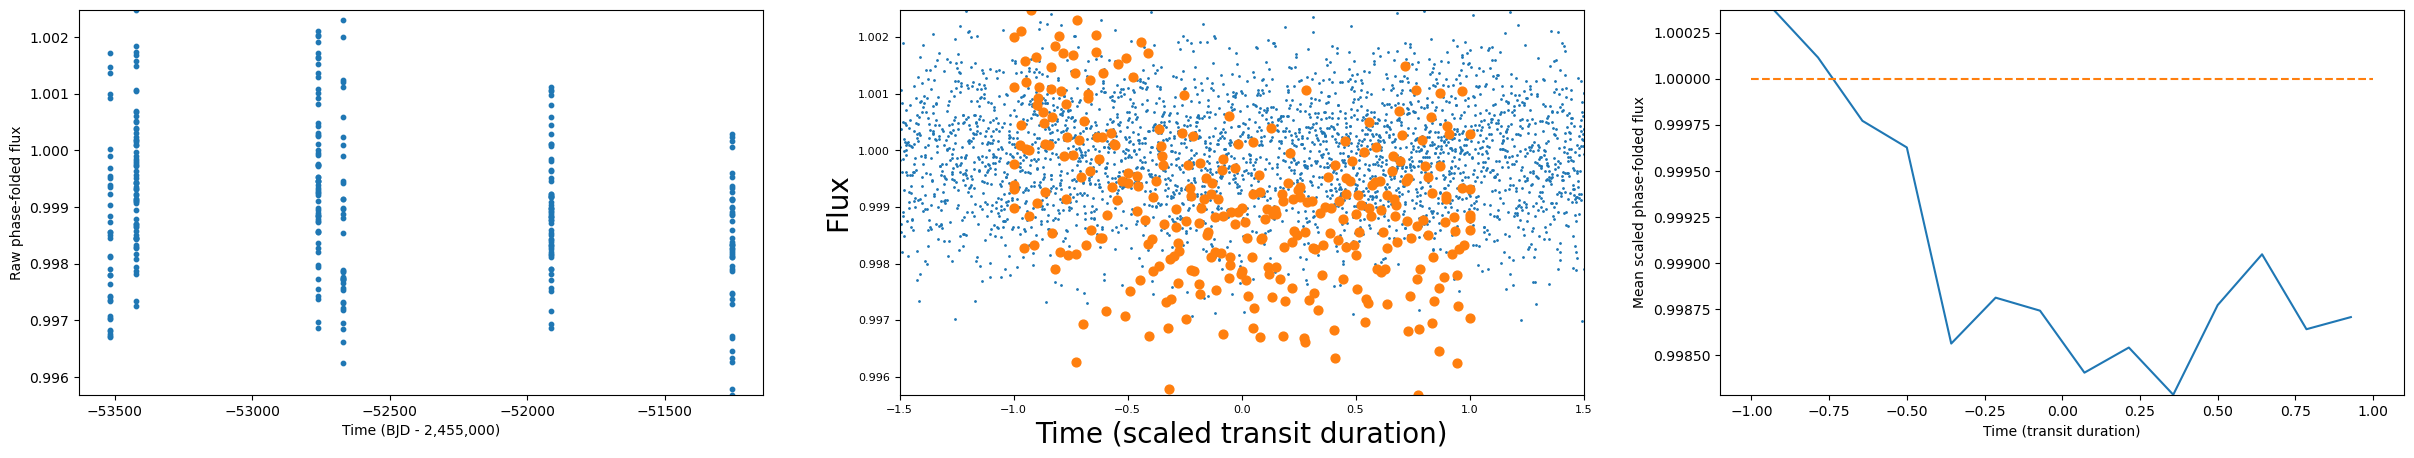



         Search Summary

System name                   : TIC260128333
mission + ID                  : TIC_260128333
Search name                   : TutorialSearch_TOI1338
Detrending name               : TutorialTOI1338
Total sectors                 : 4
Num Theta_p steps             : 128
Search parameter count        : 40017
SDE_1d (max value)            : 14.244568548354941
SDE_1d (period)               : 96.10667514777066
Pp (days)                     : 96.1067 days
ep                            : 0.0
omegap (deg)                  : 0.0 deg
thetap (deg)                  : 169.4118 deg
Transit timing (best fit)     : -53516.128, -53421.004, -53328.0, -53234.0, -53139.0, -53046.0, -52950.0, -52858.0, -52761.878, -52669.031, -52575.0, -52480.0, -52387.0, -52292.0, -52199.0, -52103.0, -52011.0, -51914.579, -51822.0, -51727.0, -51633.0, -51539.0, -51444.0, -51351.0, -51255.522, -51162.586, -51067.0

Done.


In [ ]:
# Display key search and analysis figures 
fig_dir = os.path.join("PlanetSearchOutput", SearchName)

# Note that an SDE value of above 8 is considered a detection
analysis_figs = [
    f"{ID}_{mission}SDEpaper.png",
    f"{mission}_{ID}_IndividualPlanetTransitsWiderWindow.png",
    f"{mission}_{ID}_FoldedPlanetTransits.png",
]

print("\nSearch and analysis diagnostic plots:\n")

for fname in analysis_figs:
    path = os.path.join(fig_dir, fname)
    if os.path.exists(path):
        print(f"Showing: {fname}")
        display(Image(filename=path, width=950, height=400)) 
    else:
        print(f"Missing: {fname}")


results_file = os.path.join(fig_dir, f"{mission}_{ID}_SearchResults.txt")

print("\n\n==============================")
print("         Search Summary")
print("==============================\n")

if not os.path.exists(results_file):
    print(f"SearchResults file missing: {results_file}")
else:
    summary = {}
    with open(results_file, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=", 1)
                summary[k.strip()] = v.strip()

    keys_to_show = [
        "System name",
        "mission + ID",
        "Search name",
        "Detrending name",
        "Total sectors",
        "Num Theta_p steps",
        "Search parameter count",
        "SDE_1d (max value)",
        "SDE_1d (period)",
        "Pp (days)",
        "ep",
        "omegap (deg)",
        "thetap (deg)",
        "Transit timing (best fit)"
    ]

    for k in keys_to_show:
        print(f"{k:30s}: {summary.get(k, '---')}")

print("\nDone.")


---
## **Conclusion**

This tutorial demonstration successfully executed the full **STANLEY circumbinary pipeline**, from detrending through planet search and post-search analysis, on the well-studied CBP system **TOI-1338 / TIC 260128333**.

### Key outcomes

- **Detrending completed successfully**, producing a clean, binary-corrected light curve ready for circumbinary transit searches.

- The planet search explored **40,017 parameter combinations** (over period, θₚ, eₚ, ωₚ, and fixed binary parameters), using **128 θₚ samples** across **4 sectors**.

- The **1D SDE curve** showed a **strong detection**, with **SDE ≈ 14.24** at **Pₚ ≈ 96.11 days**.

- The highest-scoring model was found at **Pₚ ≈ 96.0609 days**, consistent with the known planet TOI-1338 b.

- The best-fit parameters recovered from the grid were physically reasonable:

  - **Planet model selected by the grid:**
    - $P_p \approx 96.11 \text{ days}$
    - $e_p = 0.0$
    - $\omega_p = 0^{\circ}$
    - $\theta_p \approx 169.41^{\circ}$

- **Predicted mid-transit times** (best-fit model) were generated.  

### What this means

This notebook has demonstrated the **complete STANLEY workflow** in a compact, notebook-friendly setting:

1. High-quality detrending tailored to eclipsing binaries.  
2. A full circumbinary grid search with real multi-sector data.  
3. Period–SDE analysis and extraction of best-fit planetary parameters.  
4. Production of TTV and TDV diagnostic outputs.  
5. Generation of human-readable summary files for downstream interpretation.

Although this run was primarily a demonstration, the workflow correctly identifies the known orbital period of TOI-1338 b and produces consistent dynamical fits with a clear, high-SDE peak.

You can now adapt the tutorial settings to:

- widen the search period range  
- enable transit injections  
- increase θₚ resolution  
- run multi-sector searches  
- execute full Kepler/TESS-scale analyses on a cluster

This concludes the tutorial demonstration of the **STANLEY circumbinary planet pipeline** for TESS targets.
